In [109]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

import torch
import torch.nn as nn

import random
from tqdm import tqdm
import optuna

import pmdarima as pm

import datetime


In [2]:
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")


In [62]:
df = pd.read_csv("../../preprocessed_data/[10분 단위]아파트_층별_소비전력_2023-03-16 06.30.00 ~ 2023-08-30 10.30.00.csv", usecols=[1,2,3,4])

df

,TIMESTAMP,BUILDING,FLOOR,CONSUMPTION(W)
0,2023-03-16 06:30:00,561,1,225
1,2023-03-16 06:40:00,561,1,217
2,2023-03-16 06:50:00,561,1,212
3,2023-03-16 07:00:00,561,1,88
4,2023-03-16 07:10:00,561,1,435
...,...,...,...,...
1588813,2023-08-30 09:50:00,563,24,366
1588814,2023-08-30 10:00:00,563,24,545
1588815,2023-08-30 10:10:00,563,24,567
1588816,2023-08-30 10:20:00,563,24,547


In [73]:
df_561_1 = df.query("`BUILDING` == 561 and `FLOOR` == 1")

df_561_1

,TIMESTAMP,BUILDING,FLOOR,CONSUMPTION(W)
0,2023-03-16 06:30:00,561,1,225
1,2023-03-16 06:40:00,561,1,217
2,2023-03-16 06:50:00,561,1,212
3,2023-03-16 07:00:00,561,1,88
4,2023-03-16 07:10:00,561,1,435
...,...,...,...,...
24068,2023-08-30 09:50:00,561,1,354
24069,2023-08-30 10:00:00,561,1,354
24070,2023-08-30 10:10:00,561,1,387
24071,2023-08-30 10:20:00,561,1,505


In [74]:
df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
df_561_1.set_index(df_561_1['TIMESTAMP'], drop=True, inplace=True)
df_561_1.drop(['BUILDING', 'FLOOR','TIMESTAMP'], axis=1, inplace=True)
df_561_1


C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\2525002042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\2525002042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1.drop(['BUILDING', 'FLOOR','TIMESTAMP'], axis=1, inplace=True)


,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,225
2023-03-16 06:40:00,217
2023-03-16 06:50:00,212
2023-03-16 07:00:00,88
2023-03-16 07:10:00,435
...,...
2023-08-30 09:50:00,354
2023-08-30 10:00:00,354
2023-08-30 10:10:00,387


In [75]:
df_561_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24073 entries, 2023-03-16 06:30:00 to 2023-08-30 10:30:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   CONSUMPTION(W)  24073 non-null  int64
dtypes: int64(1)
memory usage: 376.1 KB


<Axes: xlabel='TIMESTAMP'>

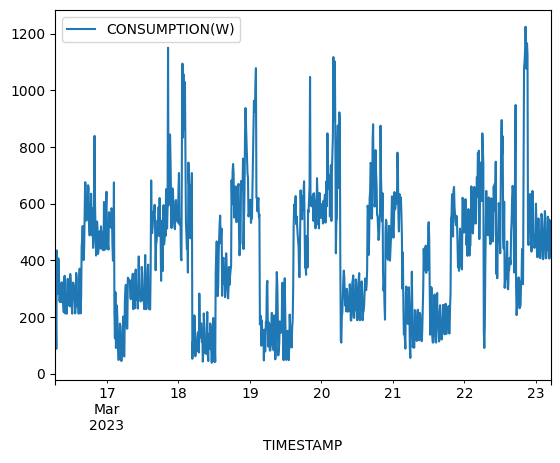

In [76]:
df_561_1.head(1000).plot()

In [9]:
df_561_2 = df.query("`BUILDING` == 561 and `FLOOR` == 2")
df_561_2.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_2.set_index('TIMESTAMP', inplace=True)
df_561_2


C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\2286428902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_2.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)


,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,256
2023-03-16 06:40:00,252
2023-03-16 06:50:00,237
2023-03-16 07:00:00,307
2023-03-16 07:10:00,304
...,...
2023-08-30 09:50:00,1244
2023-08-30 10:00:00,1309
2023-08-30 10:10:00,1233


<Axes: xlabel='TIMESTAMP'>

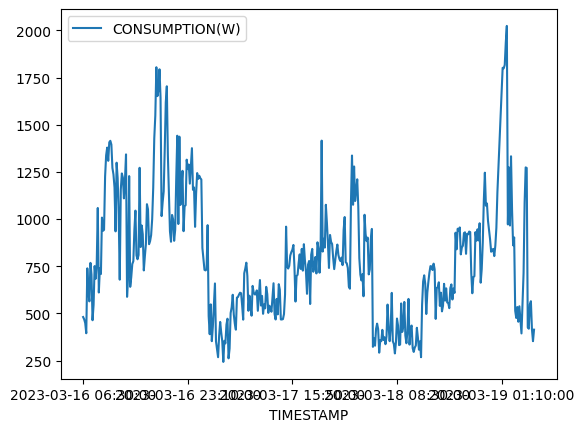

In [16]:
df_12 = df_561_1 + df_561_2

df_12.head(6*24*3).plot()

In [ ]:
df_561_3 = df.query("`BUILDING` == 561 and `FLOOR` == 3")
df_561_3.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_3.set_index('TIMESTAMP', inplace=True)
df_561_3


C:\Users\hansung\AppData\Local\Temp\ipykernel_25716\2174984375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_3.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)


,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,264
2023-03-16 06:40:00,253
2023-03-16 06:50:00,135
2023-03-16 07:00:00,297
2023-03-16 07:10:00,271
...,...
2023-08-30 09:50:00,231
2023-08-30 10:00:00,229
2023-08-30 10:10:00,226


<Axes: xlabel='TIMESTAMP'>

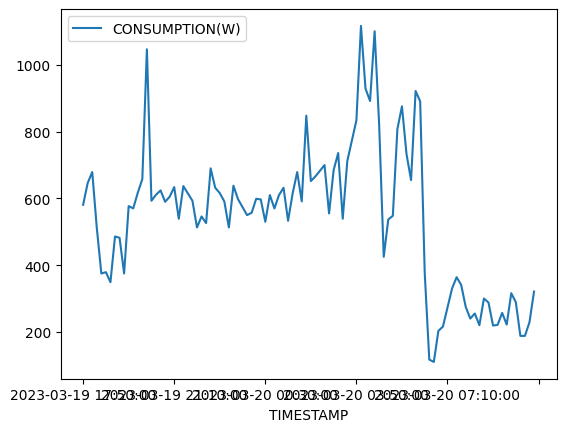

In [ ]:
df_561_1.iloc[500:600].plot()

<Axes: xlabel='TIMESTAMP'>

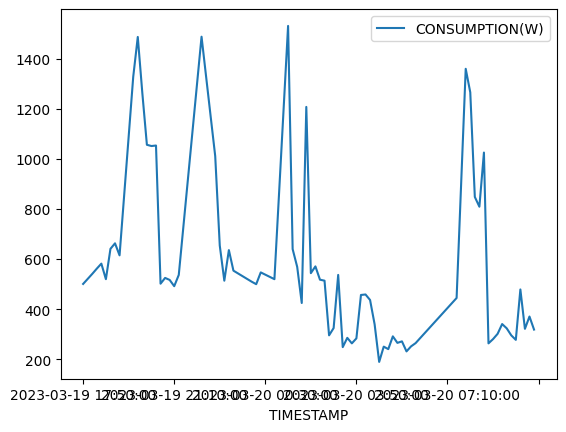

In [ ]:
df_561_2.iloc[500:600].plot()

<Axes: xlabel='TIMESTAMP'>

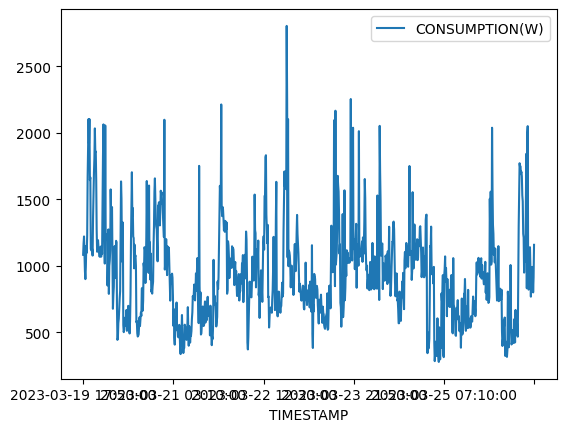

In [ ]:
df_12.iloc[500:1500].plot()

In [ ]:
df_123 = df_12 +df_561_3

df_123

,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,745
2023-03-16 06:40:00,722
2023-03-16 06:50:00,584
2023-03-16 07:00:00,692
2023-03-16 07:10:00,1010
...,...
2023-08-30 09:50:00,1829
2023-08-30 10:00:00,1892
2023-08-30 10:10:00,1846


<Axes: xlabel='TIMESTAMP'>

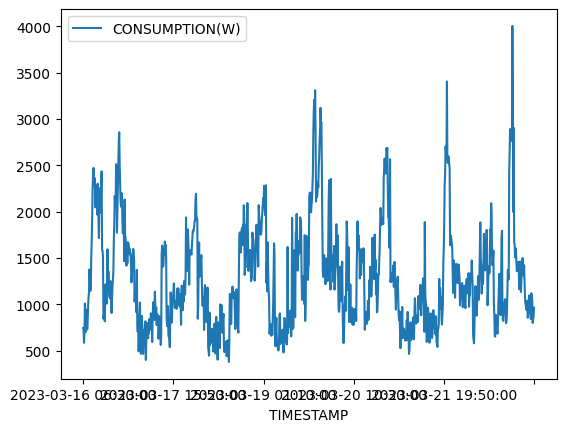

In [ ]:
df_123.iloc[:1000].plot()

In [ ]:
df_561_4 = df.query("`BUILDING` == 561 and `FLOOR` == 4")
df_561_4.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_4.set_index('TIMESTAMP', inplace=True)
df_561_4


C:\Users\hansung\AppData\Local\Temp\ipykernel_25716\2736489274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_4.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)


,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,70
2023-03-16 06:40:00,327
2023-03-16 06:50:00,188
2023-03-16 07:00:00,205
2023-03-16 07:10:00,135
...,...
2023-08-30 09:50:00,236
2023-08-30 10:00:00,285
2023-08-30 10:10:00,245


In [ ]:
df_1234 = df_561_4 + df_123
df_1234

,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:30:00,815
2023-03-16 06:40:00,1049
2023-03-16 06:50:00,772
2023-03-16 07:00:00,897
2023-03-16 07:10:00,1145
...,...
2023-08-30 09:50:00,2065
2023-08-30 10:00:00,2177
2023-08-30 10:10:00,2091


<Axes: xlabel='TIMESTAMP'>

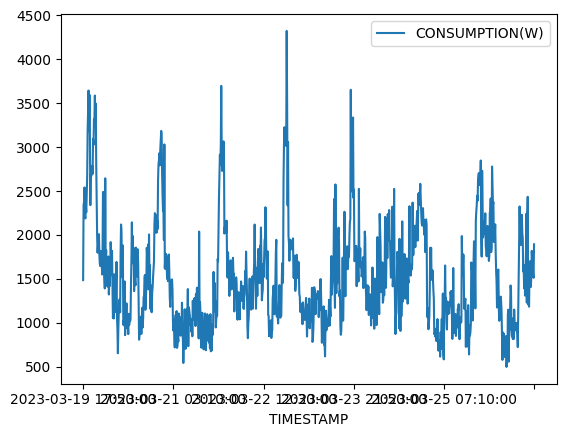

In [ ]:
df_1234.iloc[500:1500].plot()

In [77]:
scaler = MinMaxScaler()

scaler.fit(df_561_1.values)

print(scaler.n_samples_seen_)   
print(scaler.data_min_)         
print(scaler.data_max_)  

24073
[39.]
[1257.]


[[0.15270936]
 [0.14614122]
 [0.14203612]
 ...
 [0.28571429]
 [0.38259442]
 [0.41707718]]


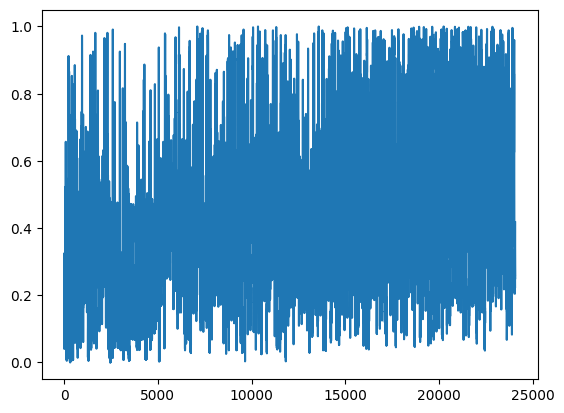

In [78]:
scaled_data = scaler.transform(df_561_1.values)
print(scaled_data)
plt.plot(scaled_data)

In [79]:
scaled_df = pd.DataFrame({'timestamp' : df_561_1.index, 'scaled_consumption' : scaled_data.flatten()})
scaled_df.set_index('timestamp', inplace=True)

scaled_df

,scaled_consumption
timestamp,
2023-03-16 06:30:00,0.152709
2023-03-16 06:40:00,0.146141
2023-03-16 06:50:00,0.142036
2023-03-16 07:00:00,0.040230
2023-03-16 07:10:00,0.325123
...,...
2023-08-30 09:50:00,0.258621
2023-08-30 10:00:00,0.258621
2023-08-30 10:10:00,0.285714


In [107]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24073 entries, 2023-03-16 06:30:00 to 2023-08-30 10:30:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   scaled_consumption  24073 non-null  float64
dtypes: float64(1)
memory usage: 892.2 KB


In [ ]:
scaled_df.loc[:'2023-06-01 00:00:00'].describe()

,scaled_consumption
count,11050.000000
mean,0.347014
std,0.188096
min,0.000000
25%,0.197044
50%,0.349343
75%,0.464696
max,1.000000


In [ ]:
scaled_df.loc['2023-06-01 00:00:00':].describe()

,scaled_consumption
count,13024.000000
mean,0.472460
std,0.215163
min,0.003284
25%,0.315271
50%,0.449097
75%,0.601806
max,1.000000


In [ ]:
int(len(scaled_df) * 0.1)

2407

In [ ]:
scaled_df[:int(len(scaled_df) * 0.9)]

In [47]:
# scaled_df = scaled_df.loc["2023-07-18 00:00:00" : '2023-08-31 23:59:00']

train_df = scaled_df[-6*24*3:-100]
train = train_df.to_numpy()

test_df = scaled_df[-100:]
test = test_df.to_numpy()

In [48]:
train_df

,scaled_consumption
timestamp,
2023-08-27 10:40:00,0.404762
2023-08-27 10:50:00,0.367816
2023-08-27 11:00:00,0.330870
2023-08-27 11:10:00,0.318555
2023-08-27 11:20:00,0.334975
...,...
2023-08-29 17:10:00,0.651067
2023-08-29 17:20:00,0.590312
2023-08-29 17:30:00,0.570608


In [49]:
test_df

,scaled_consumption
timestamp,
2023-08-29 18:00:00,0.557471
2023-08-29 18:10:00,0.651067
2023-08-29 18:20:00,0.552545
2023-08-29 18:30:00,0.614943
2023-08-29 18:40:00,0.489327
...,...
2023-08-30 09:50:00,0.258621
2023-08-30 10:00:00,0.258621
2023-08-30 10:10:00,0.285714


In [51]:
def get_ndiff(train):
    kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=6)
    return max(adf_diffs, kpss_diffs)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-603.407, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-597.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-598.797, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-600.278, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-599.777, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-605.322, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-607.294, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-605.317, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-604.885, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-603.326, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-609.279, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-602.270, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-607.306, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-607.302, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]          

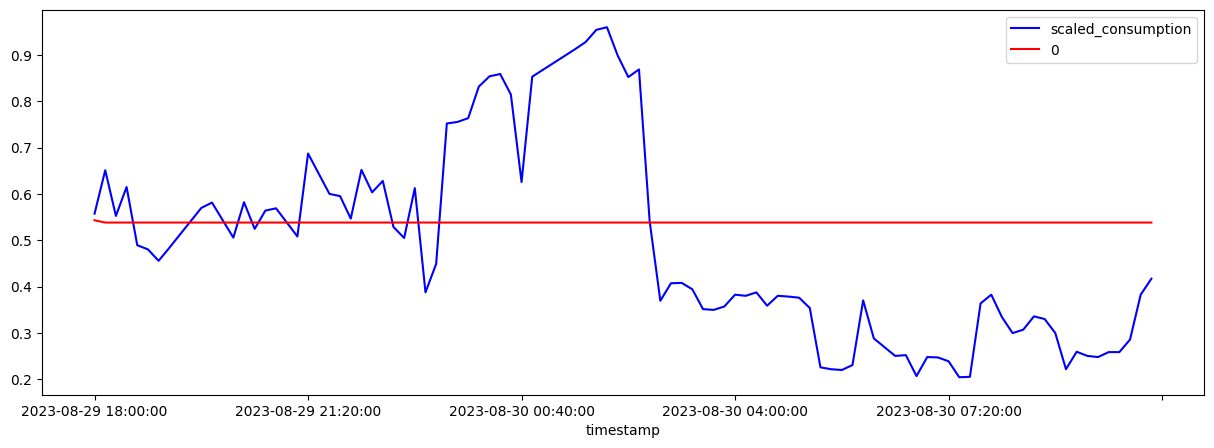

In [53]:
model = pm.auto_arima(train_df, d = get_ndiff(train_df), seasonal=False, trace=True)

fcast2 = pd.DataFrame(model.predict(100).values)

fig, ax = plt.subplots(figsize=(15,5))
test_df.plot(ax=ax, color='blue', legend=True)
fcast2.plot(ax=ax, color='red', legend=True)

print(mean_absolute_percentage_error(test_df.values, fcast2.values))

In [54]:
scaled_df

,scaled_consumption
timestamp,
2023-03-16 06:30:00,0.152709
2023-03-16 06:40:00,0.146141
2023-03-16 06:50:00,0.142036
2023-03-16 07:00:00,0.040230
2023-03-16 07:10:00,0.325123
...,...
2023-08-30 09:50:00,0.258621
2023-08-30 10:00:00,0.258621
2023-08-30 10:10:00,0.285714


In [59]:
scaled_df

<class 'pandas.core.frame.DataFrame'>
Index: 24073 entries, 2023-03-16 06:30:00 to 2023-08-30 10:30:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   scaled_consumption  24073 non-null  float64
dtypes: float64(1)
memory usage: 376.1+ KB


In [90]:
train_df[:'2023-03-16 06:50:00']

,scaled_consumption
timestamp,
2023-03-16 06:30:00,0.152709
2023-03-16 06:40:00,0.146141
2023-03-16 06:50:00,0.142036


In [91]:
train_df['2023-03-16 06:50:00':]

,scaled_consumption
timestamp,
2023-03-16 06:50:00,0.142036
2023-03-16 07:00:00,0.040230
2023-03-16 07:10:00,0.325123
2023-03-16 07:20:00,0.270936
2023-03-16 07:30:00,0.200328
...,...
2023-08-30 09:50:00,0.258621
2023-08-30 10:00:00,0.258621
2023-08-30 10:10:00,0.285714


Best window size for smallest MAPE is 530, then MAPE is 0.0764129867625343


C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\2966196334.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = model.predict(n_periods=1)[0]


<Axes: xlabel='timestamp'>

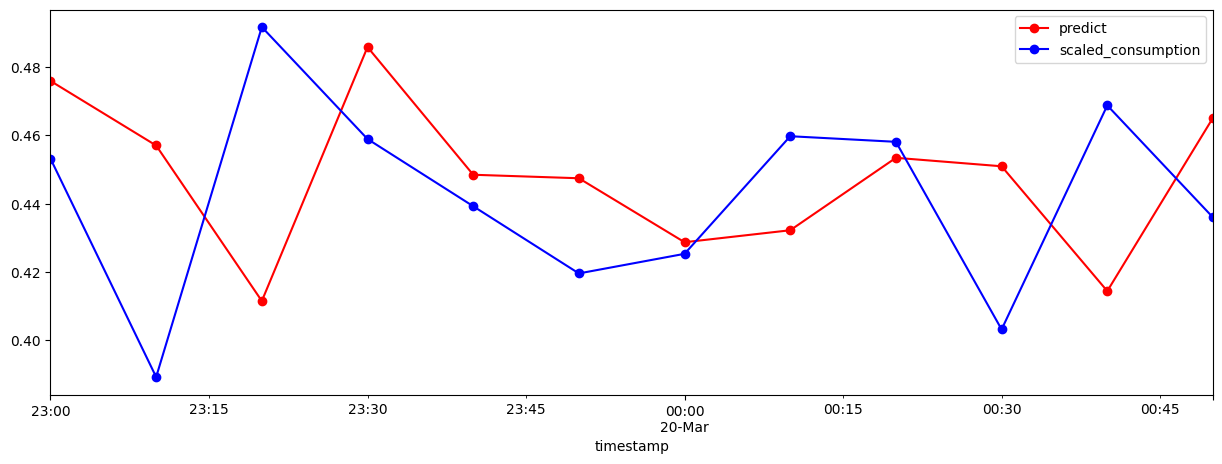

In [111]:
train_df = scaled_df
DAY_UNIT = 6 * 24

CHECK_SIZE = 12
min_mape = float('inf')
best_window_size = float('inf')

mapes = list()

MAX_STEP = 5*DAY_UNIT+1

for window_size in range(10, MAX_STEP, 10):
    end_time = train_df.index[0] + window_size * datetime.timedelta(minutes=10)
    train = train_df[:end_time]
    valid = train_df[end_time + datetime.timedelta(minutes=10) : end_time + (CHECK_SIZE+1) * datetime.timedelta(minutes=10)]

    model = pm.auto_arima(train, d=get_ndiff(train), seasonal=False)

    fcast = []
    for row in valid.itertuples():
        fcast.extend(model.predict(n_periods=1))

        model.update(row[1])

    mape = mean_absolute_percentage_error(valid.values, fcast)
    mapes.append(mape)

    if mape < min_mape :
        min_mape = mape
        best_window_size = window_size


print(f'Best window size for smallest MAPE is {best_window_size}, then MAPE is {min_mape}')

end_time = train_df.index[0] + best_window_size * datetime.timedelta(minutes=10)
train = train_df[:end_time]
valid = train_df[end_time + datetime.timedelta(minutes=10) : end_time + CHECK_SIZE * datetime.timedelta(minutes=10)]

model = pm.auto_arima(train, d=get_ndiff(train), seasonal=False)

fcast = []
for row in valid.itertuples():
    f = model.predict(n_periods=1)[0]
    fcast.append(f)

    model.update(row[1])

mape = mean_absolute_percentage_error(valid.values, fcast)

fcast = pd.DataFrame({'predict':fcast}, index=valid.index)

fig, ax = plt.subplots(figsize=(15,5))
fcast.plot(ax=ax, color='red', marker="o", legend=True)
valid.plot(ax=ax, color='blue', marker="o", legend=True)    

0.11116513402005263


<Axes: xlabel='timestamp'>

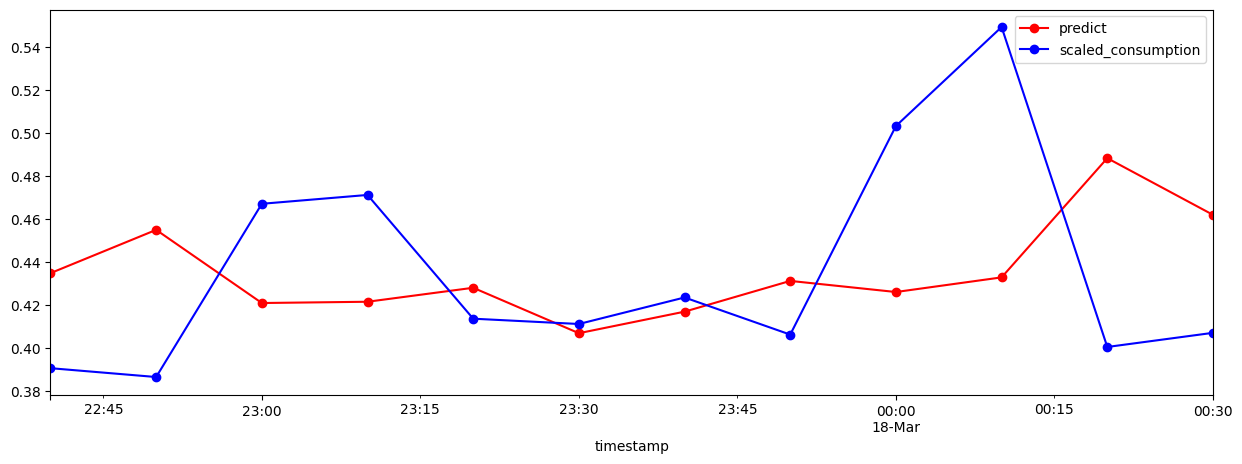

In [106]:
model = pm.auto_arima(train, d=get_ndiff(train), seasonal=False)

fcast = []
cnt = 0
for row in valid.itertuples():
    if cnt % 2 == 0:
        f = model.predict(n_periods=2)
        fcast.extend(f)
    cnt+=1
    model.update(row[1])

mape = mean_absolute_percentage_error(valid.values, fcast)
print(mape)

fcast = pd.DataFrame({'predict':fcast}, index=valid.index)

fig, ax = plt.subplots(figsize=(15,5))
fcast.plot(ax=ax, color='red', marker="o", legend=True)
valid.plot(ax=ax, color='blue', marker="o", legend=True)    

In [98]:
len(fcast)

200

<Axes: >

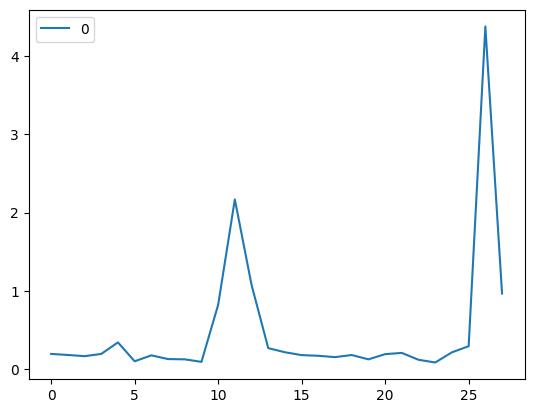

In [110]:
pd.DataFrame(mapes).plot()

<Axes: xlabel='timestamp'>

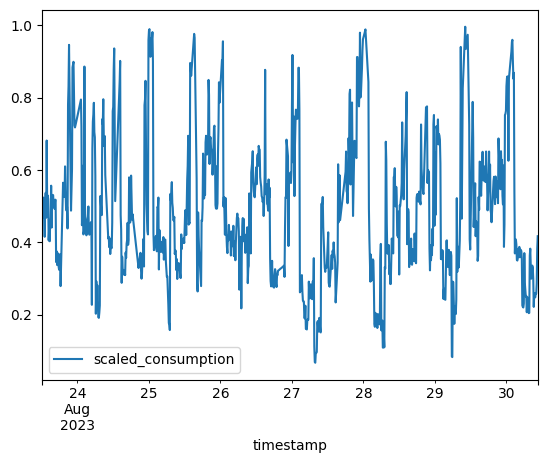

In [113]:
scaled_df.iloc[-1000:].plot()

In [114]:
raw_df = scaled_df.iloc[-1000:]

raw_df

,scaled_consumption
timestamp,
2023-08-23 12:00:00,0.525452
2023-08-23 12:10:00,0.469622
2023-08-23 12:20:00,0.516420
2023-08-23 12:30:00,0.523810
2023-08-23 12:40:00,0.467980
...,...
2023-08-30 09:50:00,0.258621
2023-08-30 10:00:00,0.258621
2023-08-30 10:10:00,0.285714


In [116]:
ow = 18
iw = ow * 2

train = raw_df[:-ow]
train = train.to_numpy()

test = raw_df[-ow:]
test = test.to_numpy()

In [117]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].reshape([-1,])

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].reshape([-1,])

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [118]:
train_dataset = windowDataset(train, input_window=iw, output_window=ow)
train_loader = DataLoader(train_dataset, batch_size=64)

In [119]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [120]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states) 
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [121]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size).to(device)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size).to(device)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0].to(device)
        input_size = inputs.shape[2].to(device)
        
        outputs = torch.zeros(batch_size, target_len, input_size).to(device)

        _, hidden = self.encoder(inputs).to(device)
        decoder_input = inputs[:,-1, :].to(device)
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden).to(device)
            out = out.squeeze(1)
            
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :].to(device)
            else:
                decoder_input = out.to(device)
            outputs[:,t,:] = out

        return outputs
	
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [141]:
import gc

def objective(trial: optuna.Trial, X, Y, train_loader):
    param = {
        'lr' : trial.suggest_categorical('lr', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        'epoch' : trial.suggest_int('epoch', 1000, 7000, 1000),
        'hidden_size' : trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    }

    print(param)

    model = lstm_encoder_decoder(input_size=1, hidden_size=param['hidden_size']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = param['lr'])
    criterion = nn.MSELoss()

    model.train()
    with tqdm(range(param['epoch'])) as tr:
        for i in tr:
            total_loss = 0.0
            for x,y in train_loader:
                optimizer.zero_grad()
                x = x.to(device).float()
                y = y.to(device).float()
                output = model(x, y, ow, 0.6)
                loss = criterion(output.to(device), y)
                loss.backward()
                optimizer.step()
                total_loss += loss.cpu().item()
            tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

    prediction = model.predict(torch.tensor(X[-iw:]).reshape(-1,1).to(device).float(), target_len=ow)

    score = mean_absolute_percentage_error(prediction, Y)
    print(score)

    gc.collect()

    return score

In [145]:
from optuna.samplers import TPESampler

# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(lambda trial : objective(trial, train, test, train_loader), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-10 12:21:29,889] A new study created in memory with name: no-name-d8ffc93b-8db0-4ba5-b39a-8894d55006c8


{'lr': 0.0001, 'epoch': 6000, 'hidden_size': 128}


  0%|          | 29/6000 [00:07<26:34,  3.74it/s, loss=0.03091]
[W 2023-11-10 12:21:37,648] Trial 0 failed with parameters: {'lr': 0.0001, 'epoch': 6000, 'hidden_size': 128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\74566662.py", line 6, in <lambda>
    study.optimize(lambda trial : objective(trial, train, test, train_loader), n_trials = 50)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_17888\290652823.py", line 26, in objective
    loss.backward()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_engine.

KeyboardInterrupt: 

In [ ]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16)

In [ ]:
learning_rate=0.01
epoch = 3000
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
predict = model.predict(torch.tensor(train[-200:]).reshape(-1,1).float(), target_len=ow)

# predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
# real = min_max_scaler.inverse_transform(real.reshape(-1,1))

0.38380401256842406


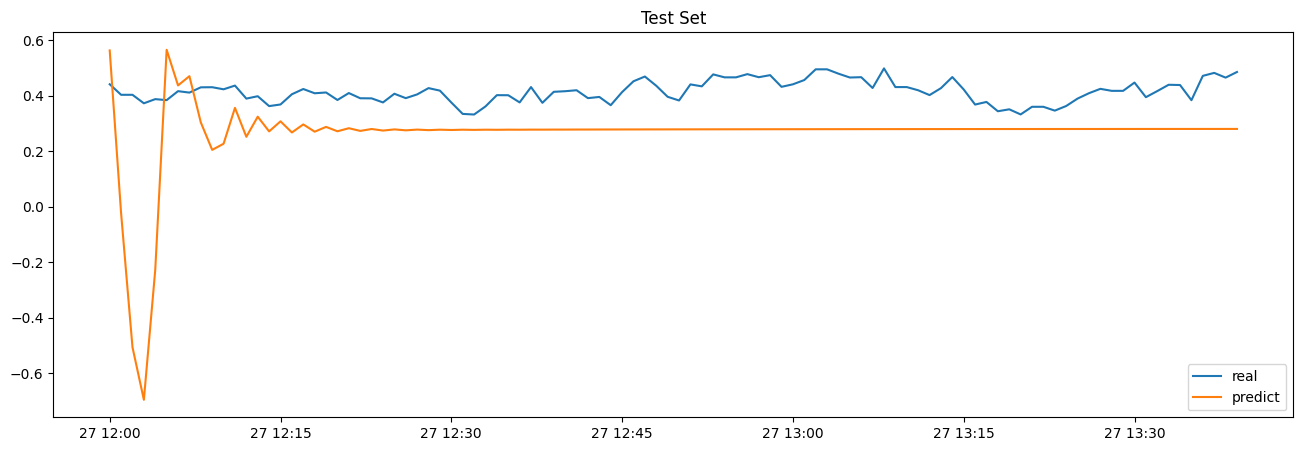

In [ ]:
print(mean_absolute_percentage_error(test_df[:100].values, predict))

plt.figure(figsize=(16,5))
plt.plot(test_df[:100], label="real")
plt.plot(test_df[:100].index, predict, label="predict")

plt.title("Test Set")
plt.legend()
plt.show()